<a href="https://colab.research.google.com/github/Tanaya006/Cellphone-prize-range-prediction/blob/main/Riceleaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Business Case
#### Prepare a complete data analysis report on Rice Leaf Diseases and Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot. By analyzing various techniques like Data Augmentation, etc.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.Importing all the necessary libraries

In [45]:
!pip install tensorflow==2.14.0

In [46]:
from google.colab.patches import cv2_imshow
import os,json,cv2,random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib


In [47]:
import PIL
from sklearn.model_selection import train_test_split
from keras.models import Sequential # importing CNN model
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout #importing the layers required to make a cnn model
from tensorflow.keras.utils import to_categorical #to categorical is used to get onehotencoder method
from tensorflow import keras # keras has layers which is required for data augmentation
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

In [48]:
for dirname, _, filenames in os.walk('/content/drive'): #this will generate the file and directory names
    for filename in filenames:
        print(os.path.join(dirname, filename)) #os.path() will return the basename of the file and join() will join the directory/file name

/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0100.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0118.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0111.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0391.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0109.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0116.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0324.JPG
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0115.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0114.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0121.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0117.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-001/Brown spot/DSC_0113.jpg
/content/drive/MyDrive/Brown spot-20200814T055208Z-0

## Loading the data

In [49]:
#creating object for each of class by providing the file path

bacterial_leaf_blight = "/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001"
brown_spot = "/content/drive/MyDrive/Brown spot-20200814T055208Z-001"
leaf_smut = "/content/drive/MyDrive/Leaf smut-20200814T055530Z-001"

In [50]:
fileList=os.listdir(bacterial_leaf_blight) #listdir() will get all files and directories
print("Number of bacterial leaf blight images: ", len(fileList)) #getting the length of the provided list

Number of bacterial leaf blight images:  1


In [51]:
# Importing pathlib to divide the filesystem paths.

import pathlib

data_dir=pathlib.Path(bacterial_leaf_blight)
print(data_dir)
data_brown=pathlib.Path(brown_spot)
print(data_brown)
data_smut=pathlib.Path(leaf_smut)
print(data_smut)

/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001
/content/drive/MyDrive/Brown spot-20200814T055208Z-001
/content/drive/MyDrive/Leaf smut-20200814T055530Z-001


In [52]:
#creating a list to strore all the bacterial images

list(data_dir.glob("*DSC*.jpg")) #glob() to search the file in data_dir object to match the pattern of (*DSC*.jpg)

[]

In [53]:
bacteria=list(data_dir.glob("Bacterial leaf blight/*")) #creating another object to store all the bacterial images
len(bacteria) #getting the length of the object

40

In [54]:
#similarly creating separate veriables for brown spot and leaf smut and getting the length of all the brown and smut images

brown=list(data_brown.glob("Brown spot/*"))
print(len(brown))
smut=list(data_smut.glob("Leaf smut/*"))
print(len(smut))


40
39


In [55]:
#creating a combine veriables withh all the images belonging to 3 classes

data={"bacteria":list(data_dir.glob("Bacterial leaf blight/*")),"brown":list(data_brown.glob("Brown spot/*")),
      "smut":list(data_smut.glob("Leaf smut/*"))}

In [56]:
data

{'bacteria': [PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0388.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0398.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0390.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0404.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0399.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0385.jpg'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0392.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf blight-20200814T055237Z-001/Bacterial leaf blight/DSC_0386.JPG'),
  PosixPath('/content/drive/MyDrive/Bacterial leaf b

In [57]:
data["smut"][5] #directly giving us the location of the image

PosixPath('/content/drive/MyDrive/Leaf smut-20200814T055530Z-001/Leaf smut/DSC_0339.jpg')

In [58]:
#assigning label to each class

labels_dict={"bacteria":0,"brown":1,"smut":2}

#3. Domain Analysis


1.   **Bacterial leaf blight** - (BLB) of rice is a bacterial disease caused by the pathogen Xanthomonas oryzae pv. oryzae (Xoo). It is one of the most serious diseases of rice and can be destructive to high-yielding cultivars.Bacterial blight of rice has high epidemic potential and has destructive tendencies to high-yielding cultivars in both temperate and tropical regions especially in Asia. There is a very large host range for Xanthomonas oryzae pv. oryzaa.
Among the grasses, hosts are Cenchrus ciliaris (Buffelgrass),Cynodon dactylon(Bermuda grass),Echinochloa crus-galli (Barnyard grass) etc.

  The symptoms are as following by which one can recognise the **BLB**.

  *   Symptoms appear on the leaves of young plants as pale-green to grey-green,
  water-soaked streaks near the leaf tip and margins.
  *   These lesions coalesce and become yellowish-white with wavy edges.
  *   The whole leaf may eventually be affected, becoming whitish or greyish and then dying.
  *   Systemic infection results in wilting, desiccation of leaves and death, particularly of young transplanted plants.
  In older plants, the leaves become yellow and then die.

  Xanthomonas oryzae causes a potentially devastating disease. Found worldwide in temperate and tropical regions, it can destroy up to 80 percent of a crop if the disease develops early. Even if it develops late, it can severely diminish the quality and yield of the grain.
  
2.  **Brown Spot** - Brown spot is a fungal disease that can infect both seedlings and mature plants. this disease caused blight on seedlings, which are grown from heavily infected seeds, and can cause 10-58% seedling mortality. Cochliobolus miyabeanus (teleomorph) is a fungus that causes brown spot disease in rice.

  **Symptopms** includes leaves, seeds, stems and inflorescences, along with the presence of brown spot. Discoloration of stems is another symptom develops from brown spot of rice disease. The fungus produces a toxin known as ophiobolin which inhibits the growth of roots, coleoptiles, and leaves.

   It was a major cause of the Bengal famine of 1943, where the crop yield was dropped by 40% to 90% and the death of 2 million people was recorded.In India and Nigeria, it can reduce total crop yield by up to 40%.Similar losses are observed in Suriname and Sumatra.



3.   **Leaf smut** - Leaf smut is caused by the fungus Entyloma oryzae, it is a widely distributed but somewhat minor disease of rice as compared to Bacterial Leaf Blight and Brown spot. The fungus produces slightly raised, angular and black spots on both sides of the leaves. Even though is it rare, it also can produce spots on leaf sheaths. Smuts are cereal and crop pathogens that most notably affect members of the grass family. The important hosts include maize, barley, wheat, oats, sugarcane, and forage grasses.

  Leaf smut of rice produces the following **symptoms**:
    *   Black spots: Slightly raised, angular black spots (sori) appear on both sides of the leaves. The spots are about 0.5 to 5.0 millimeters long and 0.5 to 1.5 millimeters wide.
    *   Yellowing leaves: Heavily infected leaves turn yellow.
    *   Dead leaf tips: The leaf tips die and turn gray.
    *   Broken spots: When wet, the spots break open and release black spores.

  Leaf smut is a minor disease that occurs late in the growing season. It's widespread where rice is grown, but it doesn't often cause serious damage. However, it can make rice vulnerable to other diseases, which can reduce yield.





# 4. EDA

In [59]:
classes={'bacteria':len(list(data_dir.glob("Bacterial leaf blight/*"))),
         'brown':len(list(data_brown.glob("Brown spot/*"))),
         'smut':len(list(data_smut.glob("Leaf smut/*")))}

Text(0, 0.5, 'Images')

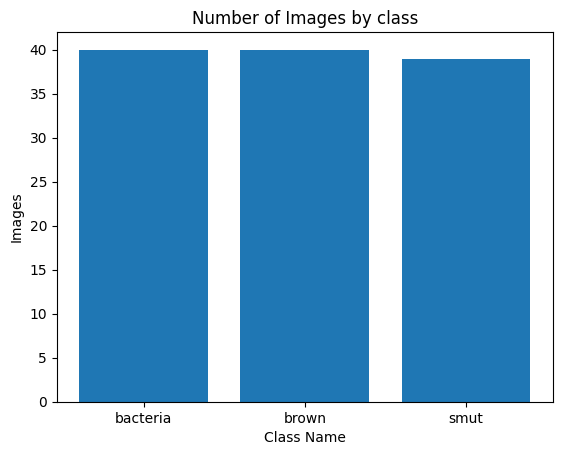

In [60]:
#checking the data if it is balanced or not

import seaborn as sns

plt.bar(classes.keys(),classes.values())
plt.title("Number of Images by class")
plt.xlabel("Class Name")
plt.ylabel("Images")

#### Insites
As we can see that all the classes have almost equal number of images hence we cn say that the datase is pretty much balanced.




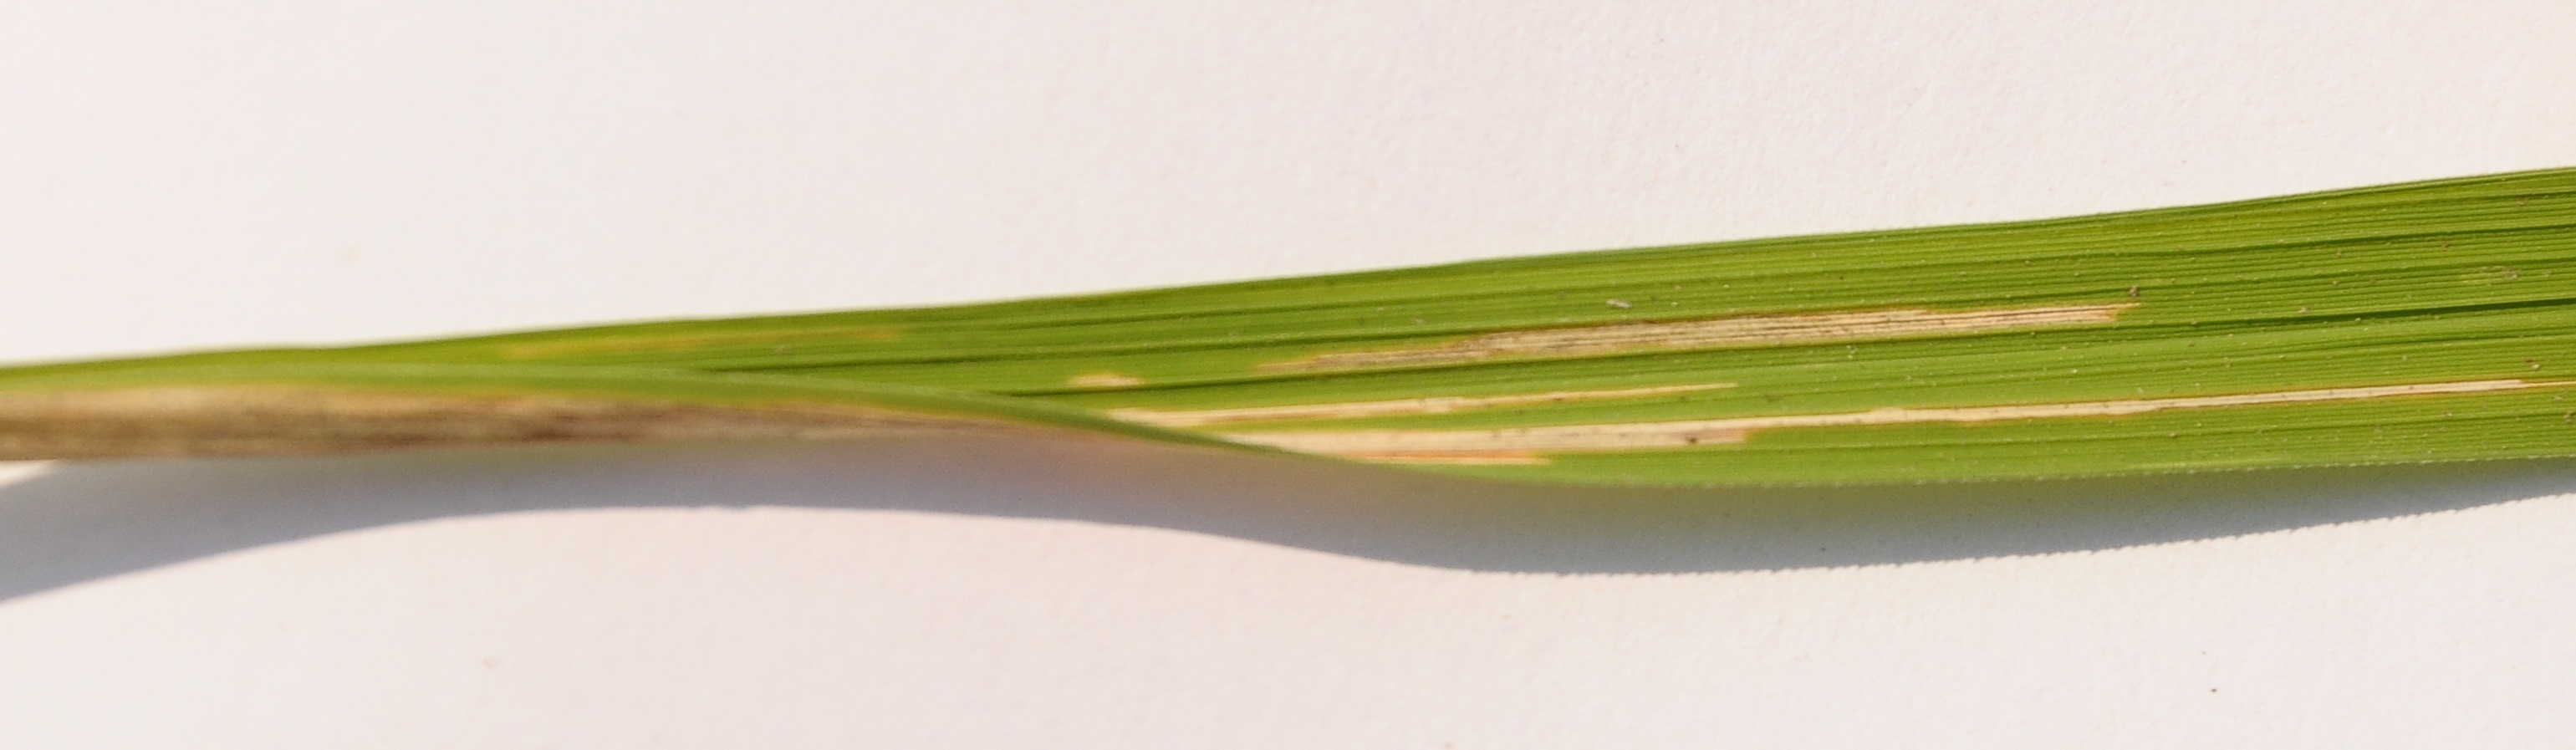

In [61]:
# visualizing few images

import PIL
PIL.Image.open(str(bacteria[19])) #Image.open() will open the image at 20th location

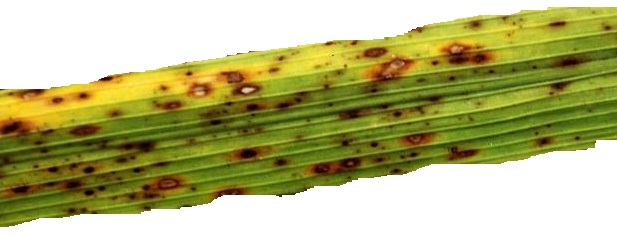

In [62]:
PIL.Image.open(str(brown[26]))  #Image.open() will open the image at 27th location

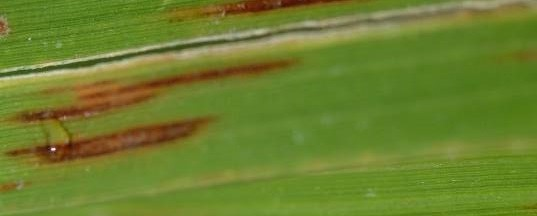

In [63]:
PIL.Image.open(str(smut[22])) #opening the image of smut on 23th location

#5. Data handeling(Preprocessing)



**Resizing the Images**

In [64]:
X,y=[],[] #creating two empty lists

for name, images in data.items():
  for image in images:
    img=cv2.imread(str(image))
    resized_img=cv2.resize(img,(180,180))
    X.append(resized_img)
    y.append(labels_dict[name])


#  imread() - will read the image from the file specified
#resize() - the image by 180 so that the top edge becomesthe bottom edge and will enable the viewer to visually connect with unseen movement
#happening around and behind the image
#append() - will add the images to the empty lists created for X and y veriables as it is being used to split the data for testing and training


In [65]:
y[:5] #getting the first 5 images classes

[0, 0, 0, 0, 0]

In [66]:
X #getting pixel size for every image in RGB colour format

[array([[[228, 231, 239],
         [224, 229, 238],
         [226, 232, 239],
         ...,
         [223, 230, 239],
         [225, 230, 239],
         [225, 230, 239]],
 
        [[225, 231, 238],
         [224, 229, 238],
         [224, 232, 239],
         ...,
         [223, 229, 239],
         [224, 231, 240],
         [225, 230, 239]],
 
        [[226, 232, 239],
         [224, 230, 237],
         [224, 231, 240],
         ...,
         [225, 230, 239],
         [226, 231, 240],
         [225, 230, 239]],
 
        ...,
 
        [[220, 229, 238],
         [219, 228, 238],
         [221, 230, 240],
         ...,
         [225, 230, 239],
         [225, 227, 237],
         [225, 230, 239]],
 
        [[219, 228, 237],
         [219, 228, 238],
         [219, 228, 238],
         ...,
         [224, 228, 239],
         [224, 226, 236],
         [224, 229, 238]],
 
        [[219, 228, 237],
         [225, 229, 240],
         [222, 228, 239],
         ...,
         [225, 229, 240],
  

In [67]:
y #getting the class of every image

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [68]:

#converting the X and y into array

X=np.array(X)
y=np.array(y)

###### Skipping the data scaling for now as first we need to split the data into training and testing.

In [69]:
X

array([[[[228, 231, 239],
         [224, 229, 238],
         [226, 232, 239],
         ...,
         [223, 230, 239],
         [225, 230, 239],
         [225, 230, 239]],

        [[225, 231, 238],
         [224, 229, 238],
         [224, 232, 239],
         ...,
         [223, 229, 239],
         [224, 231, 240],
         [225, 230, 239]],

        [[226, 232, 239],
         [224, 230, 237],
         [224, 231, 240],
         ...,
         [225, 230, 239],
         [226, 231, 240],
         [225, 230, 239]],

        ...,

        [[220, 229, 238],
         [219, 228, 238],
         [221, 230, 240],
         ...,
         [225, 230, 239],
         [225, 227, 237],
         [225, 230, 239]],

        [[219, 228, 237],
         [219, 228, 238],
         [219, 228, 238],
         ...,
         [224, 228, 239],
         [224, 226, 236],
         [224, 229, 238]],

        [[219, 228, 237],
         [225, 229, 240],
         [222, 228, 239],
         ...,
         [225, 229, 240],
        

#6. Model Creation

In [70]:
#Splitting the training and testing data

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=19)

In [71]:




len(X_train) #provided 80% of the data for training

89

In [72]:

len(X_test) #Remaining 20% of the data for testing

30

In [73]:
# Rescaling the images by dividing every pixel in every imgae by 255
rescaled_X_train=X_train/255
rescaled_X_test=X_test/255

In [74]:
#using to_categorical to convert the categorical data to numeric
num_classes=len(np.unique(y_train))
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)
print(y_train.shape)
print(y_test.shape)


(89, 3)
(30, 3)


# Defining model architecture

In [75]:
model = Sequential() #creating a veriable with CNN model

# addding 3 hidden layers

model.add(Conv2D(filters=16,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

model.summary()




# we only add input shape on 1st line,(input=images) as inbuilt layers are hidden layers and in ANN we add input once only
# relu = is the activation function for hidden layer
# pool size=2*2 matrix
# kernel size is matrix
# Dropout= will randomly deactivates the 0.1/10% nerons
# Flatten()= it will convert the array into 1D array
# 10 is input (nodes) to Ann, dense=ANN
# 3 is output layer as we have to predict 10 classes and using the softmaax as activation funsction for multiclass classification
# softmax = we are using softmax as we are doing multiclass classification

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      208       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        2080      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        8256      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 64)       

# Compile the model

In [76]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the Model

In [77]:
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hd5.keras', save_best_only=True, monitor='val_loss',mode='min')

hist = model.fit(rescaled_X_train, y_train, batch_size=30, epochs=10,callbacks=[checkpointer],verbose=1,
           shuffle=True)



# batch_size =it will have 30 batches of images
# epochs=total 10 cycles of forward and backward propogation
# callbacks= will pass the parameters to the model that are defined in checkpointer
# shuffle= it iwll shuffle the data

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 1.1371 - accuracy: 0.3820

3/3 [==============================] - 3s 569ms/step - loss: 1.1371 - accuracy: 0.3820
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.1058 - accuracy: 0.4494

3/3 [==============================] - 2s 754ms/step - loss: 1.1058 - accuracy: 0.4494
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.4944

3/3 [==============================] - 3s 977ms/step - loss: 0.9888 - accuracy: 0.4944
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.6067

3/3 [==============================] - 3s 732ms/step - loss: 0.9766 - accuracy: 0.6067
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.6067

3/3 [==============================] - 2s 549ms/step - loss: 0.9147 - accuracy: 0.6067
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.8833 - accuracy: 0.5506

3/3 [==============================] - 2s 571ms/step - loss: 0.8833 - accuracy: 0.5506
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.6629

3/3 [==============================] - 2s 566ms/step - loss: 0.8136 - accuracy: 0.6629
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.9063 - accuracy: 0.5281

3/3 [==============================] - 2s 548ms/step - loss: 0.9063 - accuracy: 0.5281
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.6629

3/3 [==============================] - 2s 562ms/step - loss: 0.7547 - accuracy: 0.6629
Epoch 10/10
3/3 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.6629

3/3 [==============================] - 2s 860ms/step - loss: 0.7566 - accuracy: 0.6629


In [78]:
score=model.evaluate(rescaled_X_test,y_test,verbose=1)
accuracy=score[1]

# print test accuracy
print('Test accuracy:',accuracy)

1/1 [==============================] - 1s 616ms/step - loss: 0.8999 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


#7. Predictions

In [79]:
predictions=model.predict(rescaled_X_test)
predictions

1/1 [==============================] - 1s 508ms/step


array([[4.0028319e-01, 2.2609968e-01, 3.7361705e-01],
       [4.8244245e-02, 7.2530901e-01, 2.2644673e-01],
       [7.3175997e-01, 1.5089583e-01, 1.1734425e-01],
       [4.5742375e-01, 3.5349491e-01, 1.8908145e-01],
       [6.0846525e-01, 2.2237681e-01, 1.6915804e-01],
       [2.9934007e-01, 4.4673738e-01, 2.5392252e-01],
       [4.4598857e-01, 2.7567577e-01, 2.7833560e-01],
       [5.5904073e-01, 2.0805864e-01, 2.3290068e-01],
       [5.1234168e-01, 2.0093806e-01, 2.8672028e-01],
       [7.6143622e-01, 1.5058869e-01, 8.7975055e-02],
       [7.0167676e-02, 6.5753067e-01, 2.7230170e-01],
       [2.4029388e-01, 2.0700613e-01, 5.5270004e-01],
       [7.2806865e-02, 7.4086416e-01, 1.8632904e-01],
       [6.0342914e-01, 1.9047005e-01, 2.0610079e-01],
       [6.5960956e-01, 1.9058146e-01, 1.4980902e-01],
       [6.0919976e-01, 1.8709470e-01, 2.0370544e-01],
       [5.8162254e-01, 2.0386899e-01, 2.1450831e-01],
       [5.1658630e-01, 3.4829310e-01, 1.3512063e-01],
       [5.4496008e-01, 2.117

In [80]:
pred=tf.nn.softmax(predictions[20]) #predicting the image on 21st position
print(pred)

tf.Tensor([0.43562502 0.29866603 0.26570892], shape=(3,), dtype=float32)


As we can tell from the above code that the model is not recognising the image correctly hence unable to assign accurate class. Also the accuracy of the model is less. In order to increase the accuracy of the model we will have to add different layers, and more filters to the convolution layer,so that the moel will train properly for us to give the correct predictions.

In [81]:
#creating another model to increase the accuracy of the model by adding more filters and changing the pooling layers

model1=Sequential()

model1.add(Conv2D(filters=128,kernel_size=2,padding='valid',activation='relu',input_shape=(180,180,3)))
model1.add(MaxPooling2D(pool_size=2,strides=2))

model1.add(Conv2D(filters=256,kernel_size=2,padding='valid',activation='relu',input_shape=(180,180,3)))
model1.add(MaxPooling2D(pool_size=2,strides=2))

model1.add(Conv2D(filters=512,kernel_size=2,padding='valid',activation='relu',input_shape=(180,180,3)))
model1.add(MaxPooling2D(pool_size=2,strides=2))

model1.add(Dropout(0.1))

#adding hidden layers to the neural network


model1.add(Flatten()) #converting the array into 1D
model1.add(Dense(25,activation='relu')) #


model1.add(Dropout(0.2))
model1.add(Dense(3,activation='softmax'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 179, 179, 128)     1664      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 88, 88, 256)       131328    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 44, 44, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 43, 43, 512)       524800    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 21, 21, 512)      

In [82]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [83]:
checkpointer=ModelCheckpoint(filepath='model.weights.best.keras',save_best_only=True,monitor='val_loss',mode='min')

hist1=model1.fit(rescaled_X_train,y_train,batch_size=30,epochs=30,callbacks=[checkpointer],verbose=1,shuffle=True)


Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.2809 

3/3 [==============================] - 45s 11s/step - loss: 1.4858 - accuracy: 0.2809
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 1.1544 - accuracy: 0.3820 

3/3 [==============================] - 31s 11s/step - loss: 1.1544 - accuracy: 0.3820
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 1.0752 - accuracy: 0.3708 

3/3 [==============================] - 30s 10s/step - loss: 1.0752 - accuracy: 0.3708
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.3708 

3/3 [==============================] - 34s 11s/step - loss: 1.0416 - accuracy: 0.3708
Epoch 5/30
3/3 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.5056 

3/3 [==============================] - 30s 10s/step - loss: 0.9471 - accuracy: 0.5056
Epoch 6/30
3/3 [==============================] - ETA: 0s - loss: 0.8546 - accuracy: 0.5955 

3/3 [==============================] - 40s 11s/step - loss: 0.8546 - accuracy: 0.5955
Epoch 7/30
3/3 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.6404 

3/3 [==============================] - 31s 11s/step - loss: 0.7504 - accuracy: 0.6404
Epoch 8/30
3/3 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.6517 

3/3 [==============================] - 30s 11s/step - loss: 0.7534 - accuracy: 0.6517
Epoch 9/30
3/3 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7191 

3/3 [==============================] - 30s 10s/step - loss: 0.6594 - accuracy: 0.7191
Epoch 10/30
3/3 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.7191 

3/3 [==============================] - 30s 10s/step - loss: 0.6837 - accuracy: 0.7191
Epoch 11/30
3/3 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7978 

3/3 [==============================] - 31s 10s/step - loss: 0.5356 - accuracy: 0.7978
Epoch 12/30
3/3 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7865 

3/3 [==============================] - 31s 10s/step - loss: 0.4524 - accuracy: 0.7865
Epoch 13/30
3/3 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.7865 

3/3 [==============================] - 31s 10s/step - loss: 0.5827 - accuracy: 0.7865
Epoch 14/30
3/3 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8090

3/3 [==============================] - 31s 10s/step - loss: 0.4610 - accuracy: 0.8090
Epoch 15/30
3/3 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8315

3/3 [==============================] - 31s 10s/step - loss: 0.3717 - accuracy: 0.8315
Epoch 16/30
3/3 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.8989

3/3 [==============================] - 31s 10s/step - loss: 0.2484 - accuracy: 0.8989
Epoch 17/30
3/3 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9101 

3/3 [==============================] - 31s 11s/step - loss: 0.2175 - accuracy: 0.9101
Epoch 18/30
3/3 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8876 

3/3 [==============================] - 31s 11s/step - loss: 0.3024 - accuracy: 0.8876
Epoch 19/30
3/3 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8764 

3/3 [==============================] - 30s 11s/step - loss: 0.3195 - accuracy: 0.8764
Epoch 20/30
3/3 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9101 

3/3 [==============================] - 30s 10s/step - loss: 0.2219 - accuracy: 0.9101
Epoch 21/30
3/3 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9213 

3/3 [==============================] - 31s 10s/step - loss: 0.2193 - accuracy: 0.9213
Epoch 22/30
3/3 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9663 

3/3 [==============================] - 32s 10s/step - loss: 0.1311 - accuracy: 0.9663
Epoch 23/30
3/3 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9775

3/3 [==============================] - 31s 10s/step - loss: 0.0953 - accuracy: 0.9775
Epoch 24/30
3/3 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9888

3/3 [==============================] - 31s 10s/step - loss: 0.0429 - accuracy: 0.9888
Epoch 25/30
3/3 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9101 

3/3 [==============================] - 40s 14s/step - loss: 0.1342 - accuracy: 0.9101
Epoch 26/30
3/3 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9438 

3/3 [==============================] - 32s 10s/step - loss: 0.0883 - accuracy: 0.9438
Epoch 27/30
3/3 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9663

3/3 [==============================] - 31s 10s/step - loss: 0.0937 - accuracy: 0.9663
Epoch 28/30
3/3 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9663

3/3 [==============================] - 31s 10s/step - loss: 0.1302 - accuracy: 0.9663
Epoch 29/30
3/3 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9663

3/3 [==============================] - 31s 10s/step - loss: 0.0560 - accuracy: 0.9663
Epoch 30/30
3/3 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9551

3/3 [==============================] - 31s 10s/step - loss: 0.1338 - accuracy: 0.9551


In [84]:
score1=model1.evaluate(rescaled_X_test,y_test,verbose=1)
accuracy_mod1=score1[1]

print('Test Accuracy:',accuracy_mod1)

1/1 [==============================] - 3s 3s/step - loss: 1.5810 - accuracy: 0.6667
Test Accuracy: 0.6666666865348816


In [85]:
predictions1=model1.predict(rescaled_X_test)
predictions1

1/1 [==============================] - 3s 3s/step


array([[1.30825043e-02, 3.71656753e-02, 9.49751854e-01],
       [1.80195593e-06, 8.13721001e-01, 1.86277077e-01],
       [9.98856664e-01, 1.13426079e-03, 9.05456636e-06],
       [9.69927132e-01, 3.00727412e-02, 1.07938135e-07],
       [2.42658913e-01, 7.53849447e-01, 3.49157490e-03],
       [5.29206125e-04, 9.99322236e-01, 1.48558436e-04],
       [7.68003811e-04, 9.34886158e-01, 6.43459335e-02],
       [8.04780647e-02, 7.86309659e-01, 1.33212298e-01],
       [9.98012304e-01, 5.41772679e-05, 1.93340145e-03],
       [9.99847174e-01, 1.52583845e-04, 2.68914818e-07],
       [2.98795087e-04, 8.80638123e-01, 1.19063027e-01],
       [6.90693385e-04, 3.16513142e-05, 9.99277592e-01],
       [2.82125150e-08, 9.99998987e-01, 1.00661339e-06],
       [7.37543225e-01, 2.61545986e-01, 9.10797680e-04],
       [9.35214162e-01, 4.10278887e-02, 2.37578284e-02],
       [7.16013134e-01, 2.77046949e-01, 6.93994947e-03],
       [2.09719360e-01, 7.89959013e-01, 3.21655476e-04],
       [6.69755161e-01, 3.30227

In [86]:
pred1 = tf.nn.softmax(predictions1[11])  #predicting the class of the image on 12th position
print(pred1)

tf.Tensor([0.21214378 0.212004   0.5758523 ], shape=(3,), dtype=float32)


#8. Data Augmentation

In [80]:
!pip install tensorflow==2.14.0

In [87]:
data_augmentation = keras.Sequential(
  [

    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.9),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomFlip('vertical'),
    layers.experimental.preprocessing.RandomHeight(0.2),
    layers.experimental.preprocessing.RandomWidth(0.2)
  ])

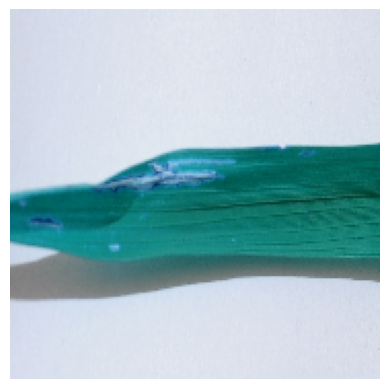

In [88]:
plt.axis('off')
plt.imshow(X[30])

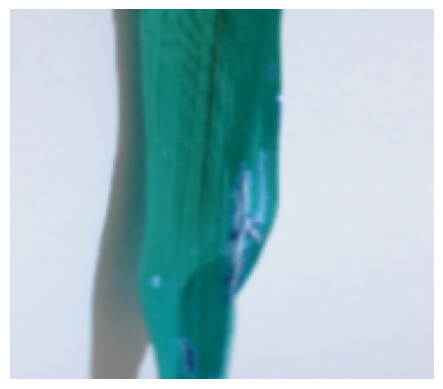

In [89]:
plt.axis('off')
plt.imshow(data_augmentation(X)[30].numpy().astype("uint8")) #image after data augmentation

In [90]:
#creating another model to increase the accuracy of the model by adding more filters and changing the pooling layers

model_aug=Sequential()

data_augmentation,
model_aug.add(Conv2D(filters=128,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model_aug.add(MaxPooling2D(pool_size=3,strides=3))

model_aug.add(Conv2D(filters=256,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model_aug.add(MaxPooling2D(pool_size=3,strides=3))

model_aug.add(Conv2D(filters=512,kernel_size=2,padding='same',activation='relu',input_shape=(180,180,3)))
model_aug.add(MaxPooling2D(pool_size=3,strides=3))

model_aug.add(Dropout(0.1))

#adding hidden layers to the neural network


model_aug.add(Flatten()) #converting the array into 1D
model_aug.add(Dense(30,activation='relu')) #


model_aug.add(Dropout(0.2))
model_aug.add(Dense(3,activation='softmax'))

model_aug.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 128)     1664      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 256)       131328    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 20, 20, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 512)       524800    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 6, 6, 512)        

In [91]:
model_aug.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [92]:
checkpointer=ModelCheckpoint(filepath='model.weights.best.keras',save_best_only=True, moniter='val_loss',)

hist2=model_aug.fit(rescaled_X_train,y_train,batch_size=30,epochs=40,callbacks=[checkpointer],verbose=1,shuffle=True)

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.2098 - accuracy: 0.3146

3/3 [==============================] - 15s 4s/step - loss: 1.2098 - accuracy: 0.3146
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.0939 - accuracy: 0.3933

3/3 [==============================] - 14s 4s/step - loss: 1.0939 - accuracy: 0.3933
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.0840 - accuracy: 0.3820

3/3 [==============================] - 14s 4s/step - loss: 1.0840 - accuracy: 0.3820
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.3820

3/3 [==============================] - 14s 5s/step - loss: 1.0860 - accuracy: 0.3820
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.4607

3/3 [==============================] - 14s 5s/step - loss: 1.0563 - accuracy: 0.4607
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 1.0424 - accuracy: 0.4494

3/3 [==============================] - 14s 5s/step - loss: 1.0424 - accuracy: 0.4494
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.9994 - accuracy: 0.4944

3/3 [==============================] - 13s 5s/step - loss: 0.9994 - accuracy: 0.4944
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.6180

3/3 [==============================] - 13s 4s/step - loss: 0.9675 - accuracy: 0.6180
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.9364 - accuracy: 0.4270

3/3 [==============================] - 14s 4s/step - loss: 0.9364 - accuracy: 0.4270
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.9238 - accuracy: 0.5618

3/3 [==============================] - 14s 4s/step - loss: 0.9238 - accuracy: 0.5618
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.6067

3/3 [==============================] - 14s 5s/step - loss: 0.9253 - accuracy: 0.6067
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.5169

3/3 [==============================] - 14s 5s/step - loss: 0.9162 - accuracy: 0.5169
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.6180

3/3 [==============================] - 14s 5s/step - loss: 0.8617 - accuracy: 0.6180
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.6067

3/3 [==============================] - 14s 5s/step - loss: 0.8890 - accuracy: 0.6067
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.5843

3/3 [==============================] - 13s 5s/step - loss: 0.8235 - accuracy: 0.5843
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.6854

3/3 [==============================] - 13s 4s/step - loss: 0.8082 - accuracy: 0.6854
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.7914 - accuracy: 0.6966

3/3 [==============================] - 14s 4s/step - loss: 0.7914 - accuracy: 0.6966
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.6742

3/3 [==============================] - 16s 4s/step - loss: 0.7437 - accuracy: 0.6742
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.7684 - accuracy: 0.7191

3/3 [==============================] - 14s 4s/step - loss: 0.7684 - accuracy: 0.7191
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.7079

3/3 [==============================] - 14s 5s/step - loss: 0.7249 - accuracy: 0.7079
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.7416

3/3 [==============================] - 14s 5s/step - loss: 0.7537 - accuracy: 0.7416
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6742

3/3 [==============================] - 14s 5s/step - loss: 0.7312 - accuracy: 0.6742
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7303

3/3 [==============================] - 13s 5s/step - loss: 0.7168 - accuracy: 0.7303
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7978

3/3 [==============================] - 13s 4s/step - loss: 0.6666 - accuracy: 0.7978
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.7303

3/3 [==============================] - 13s 4s/step - loss: 0.6401 - accuracy: 0.7303
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7753

3/3 [==============================] - 14s 4s/step - loss: 0.5722 - accuracy: 0.7753
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.8090

3/3 [==============================] - 14s 5s/step - loss: 0.5912 - accuracy: 0.8090
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7753

3/3 [==============================] - 14s 5s/step - loss: 0.5605 - accuracy: 0.7753
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8539

3/3 [==============================] - 17s 7s/step - loss: 0.5580 - accuracy: 0.8539
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.8202

3/3 [==============================] - 19s 5s/step - loss: 0.5355 - accuracy: 0.8202
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8427

3/3 [==============================] - 14s 5s/step - loss: 0.4636 - accuracy: 0.8427
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.8202

3/3 [==============================] - 14s 5s/step - loss: 0.4682 - accuracy: 0.8202
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8090

3/3 [==============================] - 14s 5s/step - loss: 0.4702 - accuracy: 0.8090
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8315

3/3 [==============================] - 14s 5s/step - loss: 0.4201 - accuracy: 0.8315
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7978

3/3 [==============================] - 13s 5s/step - loss: 0.5036 - accuracy: 0.7978
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8876

3/3 [==============================] - 13s 4s/step - loss: 0.3696 - accuracy: 0.8876
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8989

3/3 [==============================] - 14s 4s/step - loss: 0.3153 - accuracy: 0.8989
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8764

3/3 [==============================] - 14s 4s/step - loss: 0.3599 - accuracy: 0.8764
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8989

3/3 [==============================] - 14s 5s/step - loss: 0.3281 - accuracy: 0.8989
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9326

3/3 [==============================] - 14s 5s/step - loss: 0.2586 - accuracy: 0.9326


In [93]:
pred2=model_aug.predict(rescaled_X_test)
pred2

1/1 [==============================] - 1s 1s/step


array([[5.24247624e-03, 3.49415913e-02, 9.59815919e-01],
       [4.41091321e-03, 4.15869877e-02, 9.54002023e-01],
       [8.66800010e-01, 9.27048642e-03, 1.23929426e-01],
       [9.43699241e-01, 2.18436169e-03, 5.41162975e-02],
       [2.63543010e-01, 3.19524139e-01, 4.16932881e-01],
       [1.37534924e-03, 9.48244631e-01, 5.03800698e-02],
       [1.41779363e-01, 2.80214310e-01, 5.78006208e-01],
       [3.01171988e-01, 1.26857400e-01, 5.71970522e-01],
       [9.28427160e-01, 2.04466796e-03, 6.95281103e-02],
       [9.53677416e-01, 7.02406047e-04, 4.56203371e-02],
       [2.83116847e-03, 1.32966891e-01, 8.64201963e-01],
       [2.73160025e-04, 1.34606892e-02, 9.86266136e-01],
       [9.77838933e-01, 3.09711264e-04, 2.18514372e-02],
       [8.30772936e-01, 1.64395180e-02, 1.52787447e-01],
       [9.34827864e-01, 1.62499235e-03, 6.35471195e-02],
       [4.61902380e-01, 1.74146462e-02, 5.20682871e-01],
       [6.08316243e-01, 1.91203192e-01, 2.00480536e-01],
       [8.22908401e-01, 6.68958

In [94]:
score2=model_aug.evaluate(rescaled_X_test,y_test,verbose=1)
accuracy_dtaug=score2[1]

print('Accuarcy:',accuracy_dtaug)

1/1 [==============================] - 1s 1s/step - loss: 0.8321 - accuracy: 0.7333
Accuarcy: 0.7333333492279053


In [95]:
prediction2 = tf.nn.softmax(pred2[11])  #predicting the class of the image on 12th position
print(prediction2)

tf.Tensor([0.2130494  0.21587761 0.571073  ], shape=(3,), dtype=float32)


In [96]:
from keras.layers import Conv3D, MaxPooling3D

# Creating another model to get better performance

dt_aug=Sequential()

dt_aug.add(Conv2D(filters=128,kernel_size=2,activation='relu',padding='valid',input_shape=(180,180,3)))
dt_aug.add(MaxPooling2D(pool_size=3,strides=3))

dt_aug.add(Conv2D(filters=256,kernel_size=2,activation='relu',padding='valid',input_shape=(180,180,3)))
dt_aug.add(MaxPooling2D(pool_size=3,strides=3))

dt_aug.add(Conv2D(filters=512,kernel_size=2,activation='relu',padding='valid',input_shape=(180,180,3)))
dt_aug.add(MaxPooling2D(pool_size=3,strides=3))
dt_aug.add(Dropout(0.2))

dt_aug.add(Flatten())
dt_aug.add(Dense(25,activation='relu'))

dt_aug.add(Dropout(0.2))
dt_aug.add(Dense(3,activation='softmax'))

dt_aug.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 179, 179, 128)     1664      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 58, 58, 256)       131328    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 19, 19, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 18, 18, 512)       524800    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 6, 6, 512)        

In [97]:
dt_aug.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')

In [105]:
checkpointer=ModelCheckpoint(filepath='model.weights.best.keras',save_best_only=True, moniter='val_loss',)

hist2=dt_aug.fit(rescaled_X_train,y_train,batch_size=30,epochs=40,callbacks=[checkpointer],verbose=1,shuffle=True)

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9326

3/3 [==============================] - 13s 4s/step - loss: 0.2207 - accuracy: 0.9326
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9213

3/3 [==============================] - 13s 5s/step - loss: 0.2495 - accuracy: 0.9213
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8315

3/3 [==============================] - 13s 5s/step - loss: 0.3307 - accuracy: 0.8315
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.9213

3/3 [==============================] - 12s 4s/step - loss: 0.2908 - accuracy: 0.9213
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9101

3/3 [==============================] - 12s 4s/step - loss: 0.2299 - accuracy: 0.9101
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9438

3/3 [==============================] - 13s 4s/step - loss: 0.2160 - accuracy: 0.9438
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.1813 - accuracy: 0.9438
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9101

3/3 [==============================] - 13s 5s/step - loss: 0.1759 - accuracy: 0.9101
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9101

3/3 [==============================] - 15s 5s/step - loss: 0.2146 - accuracy: 0.9101
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.8876

3/3 [==============================] - 20s 6s/step - loss: 0.2137 - accuracy: 0.8876
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9551

3/3 [==============================] - 13s 4s/step - loss: 0.1608 - accuracy: 0.9551
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.8876

3/3 [==============================] - 12s 4s/step - loss: 0.2115 - accuracy: 0.8876
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8764

3/3 [==============================] - 13s 4s/step - loss: 0.2672 - accuracy: 0.8764
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8427

3/3 [==============================] - 13s 4s/step - loss: 0.2637 - accuracy: 0.8427
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.8989

3/3 [==============================] - 13s 5s/step - loss: 0.2359 - accuracy: 0.8989
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9551

3/3 [==============================] - 13s 5s/step - loss: 0.1520 - accuracy: 0.9551
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.8764

3/3 [==============================] - 11s 4s/step - loss: 0.1991 - accuracy: 0.8764
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9888

3/3 [==============================] - 13s 4s/step - loss: 0.1113 - accuracy: 0.9888
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9663

3/3 [==============================] - 13s 4s/step - loss: 0.1261 - accuracy: 0.9663
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.0941 - accuracy: 0.9438
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9551

3/3 [==============================] - 13s 5s/step - loss: 0.1401 - accuracy: 0.9551
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9438

3/3 [==============================] - 12s 4s/step - loss: 0.1104 - accuracy: 0.9438
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9551

3/3 [==============================] - 12s 4s/step - loss: 0.1208 - accuracy: 0.9551
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 1.0000

3/3 [==============================] - 13s 4s/step - loss: 0.0756 - accuracy: 1.0000
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.1487 - accuracy: 0.9438
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.1422 - accuracy: 0.9438
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 1.0000

3/3 [==============================] - 13s 5s/step - loss: 0.0718 - accuracy: 1.0000
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9438

3/3 [==============================] - 12s 4s/step - loss: 0.1409 - accuracy: 0.9438
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9326

3/3 [==============================] - 13s 4s/step - loss: 0.1359 - accuracy: 0.9326
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 1.0000

3/3 [==============================] - 13s 4s/step - loss: 0.0726 - accuracy: 1.0000
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9551

3/3 [==============================] - 13s 5s/step - loss: 0.1052 - accuracy: 0.9551
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.1448 - accuracy: 0.9438
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9663

3/3 [==============================] - 11s 4s/step - loss: 0.0879 - accuracy: 0.9663
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9775

3/3 [==============================] - 13s 4s/step - loss: 0.0803 - accuracy: 0.9775
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9438

3/3 [==============================] - 13s 4s/step - loss: 0.0831 - accuracy: 0.9438
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9775

3/3 [==============================] - 13s 5s/step - loss: 0.0491 - accuracy: 0.9775
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9438

3/3 [==============================] - 13s 5s/step - loss: 0.0985 - accuracy: 0.9438
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9663

3/3 [==============================] - 12s 4s/step - loss: 0.0652 - accuracy: 0.9663
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9775

3/3 [==============================] - 12s 4s/step - loss: 0.0687 - accuracy: 0.9775
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9326

3/3 [==============================] - 13s 4s/step - loss: 0.0962 - accuracy: 0.9326


In [106]:

pred3=dt_aug.predict(rescaled_X_test)
pred3

1/1 [==============================] - 2s 2s/step


array([[5.4256329e-06, 3.3759007e-03, 9.9661857e-01],
       [5.9082458e-04, 7.8024453e-01, 2.1916467e-01],
       [9.9772400e-01, 2.2758627e-03, 1.1920101e-07],
       [9.9981403e-01, 1.8590038e-04, 3.1094113e-10],
       [3.1501416e-02, 8.3678758e-01, 1.3171102e-01],
       [1.0556684e-05, 9.9093127e-01, 9.0581859e-03],
       [3.1079220e-02, 3.1460875e-01, 6.5431190e-01],
       [5.2071791e-02, 2.0303033e-01, 7.4489790e-01],
       [9.9686897e-01, 2.3836090e-04, 2.8927107e-03],
       [9.9997061e-01, 2.9378674e-05, 4.1603371e-10],
       [7.3935080e-04, 1.2432365e-01, 8.7493700e-01],
       [1.5119499e-05, 9.5693109e-04, 9.9902791e-01],
       [9.9150968e-01, 8.4903967e-03, 3.8598461e-11],
       [9.9020416e-01, 9.7859791e-03, 9.8060682e-06],
       [9.9756664e-01, 1.9463461e-03, 4.8701389e-04],
       [7.8612065e-01, 2.0283760e-01, 1.1041730e-02],
       [8.3625510e-02, 8.8336587e-01, 3.3008534e-02],
       [2.3577400e-01, 7.6422602e-01, 2.7173535e-09],
       [1.8570411e-01, 2.292

In [107]:
score3=dt_aug.evaluate(rescaled_X_test,y_test,verbose=1)
accuracy_dtaug2=score3[0]

print('Accuarcy:',accuracy_dtaug2)

1/1 [==============================] - 1s 1s/step - loss: 0.9755 - accuracy: 0.7333
Accuarcy: 0.975530743598938


In [108]:
prediction3 = tf.nn.softmax(pred3[11])  #predicting the class of the image on 12th position
print(prediction3)

tf.Tensor([0.21201974 0.21221952 0.5757607 ], shape=(3,), dtype=float32)


# Visualization of predicted labels

In [109]:
np.argmax(y_test,axis=1)

array([2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2,
       2, 2, 2, 2, 0, 2, 0, 0])

In [110]:
label=["bacteria","brwon","smut"]

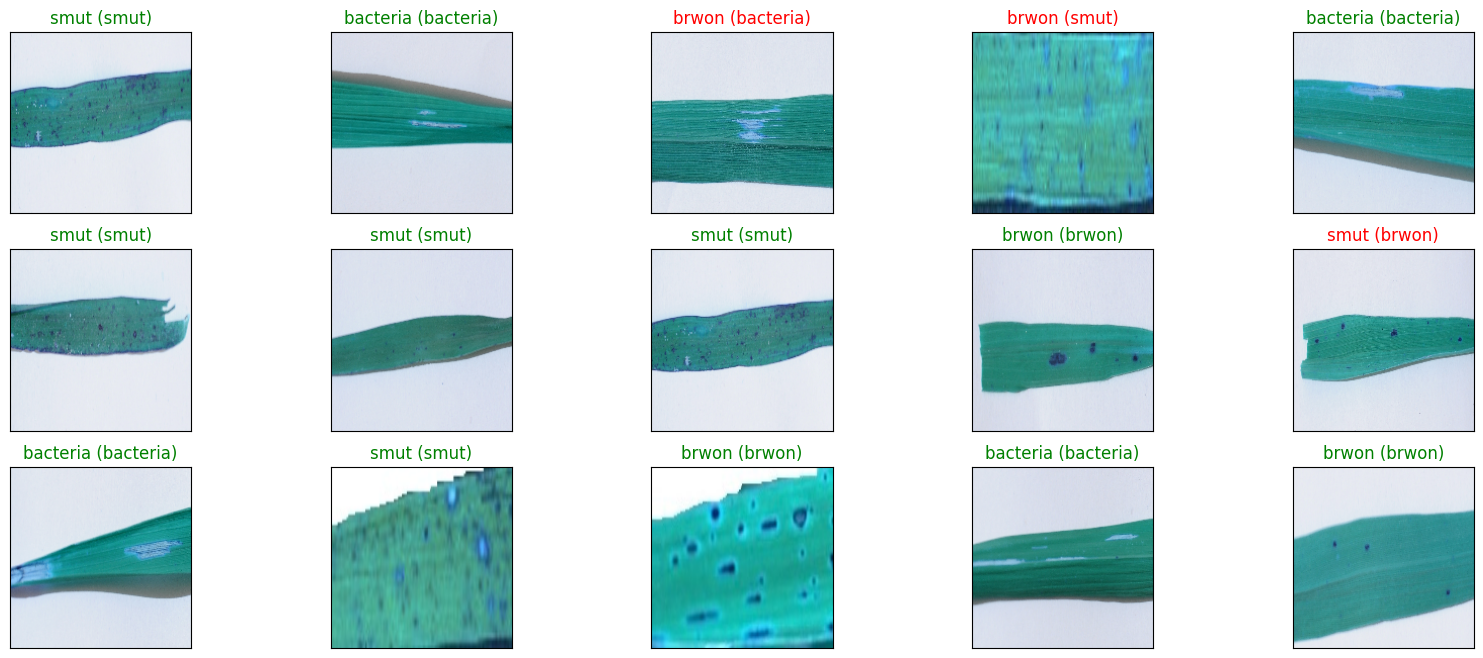

In [112]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(pred3[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(label[predict_index],
                                  label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))


# Model Comparision

In [113]:
import pandas as pd

In [114]:
models=pd.DataFrame({'Models':['model','model1','model_aug','dt_aug'],
                      'Scores':[100*round(accuracy,4),100*round(accuracy_mod1,4),100*round(accuracy_dtaug,4),100*round(accuracy_dtaug2,4)]})

In [115]:
new=pd.DataFrame(models.sort_values(by='Scores',ascending=False))

In [116]:
new

Models  Scores
3     dt_aug   97.55
2  model_aug   73.33
1     model1   66.67
0      model   60.00

In [117]:
accuracy_dtaug2

0.975530743598938

<Axes: xlabel='Models', ylabel='Scores'>

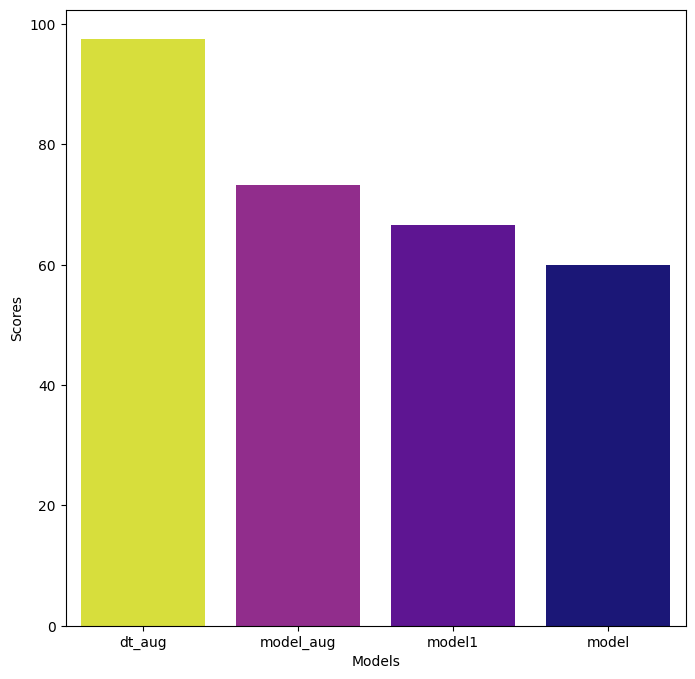

In [118]:
plt.figure(figsize=(8,8))
sns.barplot(x='Models',y='Scores',palette='plasma',hue='Scores',legend=False,data=new)

To create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot 4 CNN models are used with different architecture in each model.

Along with 2 CNN models with basic architecture Data Augmentation is done. After the Data Augmentation we can see the model2 and model3 with increased accuracy and better prediction as compared with the model and model1, hence Model2 and model3 are better for production.